# Uncomment to install all necessary libraries

In [1]:
#!pip install numpy pandas matplotlib torch scikit-learn Pillow seaborn

# Import all necessary libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, zipfile, fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.utils import shuffle
from PIL import Image
from glob import glob
from random import sample

In [3]:
# Enable GPU if available (defaults to CPU)
if torch.cuda.is_available():
    print('Using GPU for this demo...')
    device = torch.device("cuda:0")
else:
    print('Using CPU for this demo...')
    device = torch.device("cpu")

Using CPU for this demo...


# Unzip imagefiles (training data)

In [4]:
import zipfile, fnmatch

indir = 'train_images_resized_500'
pattern = '*.zip'

datadir = 'train_images_500' # where we will be storing all training images
os.system(f'rm -r {datadir}')
os.system(f'mkdir {datadir}')

for root, dirs, files in os.walk(indir):
    for filename in fnmatch.filter(files, pattern):
        filepath = os.path.join(indir, filename)
        
        # Unzip files
        print(f'Unzipping {filepath}')
        os.system(f'unzip -q {filepath}')
        
        # Move all imagefiles under nested directory to main data directory
        subdir = filepath.replace('.zip', '')
        os.system(f'mv {subdir}/* {datadir}')
        os.system(f'rm -r {subdir}')

Unzipping train_images_resized_500/24.zip
Unzipping train_images_resized_500/30.zip
Unzipping train_images_resized_500/18.zip
Unzipping train_images_resized_500/19.zip
Unzipping train_images_resized_500/31.zip
Unzipping train_images_resized_500/25.zip
Unzipping train_images_resized_500/27.zip
Unzipping train_images_resized_500/26.zip
Unzipping train_images_resized_500/32.zip
Unzipping train_images_resized_500/22.zip
Unzipping train_images_resized_500/23.zip
Unzipping train_images_resized_500/09.zip
Unzipping train_images_resized_500/21.zip
Unzipping train_images_resized_500/20.zip
Unzipping train_images_resized_500/08.zip
Unzipping train_images_resized_500/05.zip
Unzipping train_images_resized_500/11.zip
Unzipping train_images_resized_500/10.zip
Unzipping train_images_resized_500/04.zip
Unzipping train_images_resized_500/12.zip
Unzipping train_images_resized_500/06.zip
Unzipping train_images_resized_500/07.zip
Unzipping train_images_resized_500/13.zip
Unzipping train_images_resized_500

# Get training data

In [5]:
def get_abspath(directory):
    """Function returns list of absolute paths under root directory"""
    abspaths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            abspaths.append(os.path.join(root, file))
    return abspaths

In [6]:
def preprocess(filepath, dirpath):
    """Function takes in csv filepath and images directory"""
    
    # Read data into pandas dataframe
    data = pd.read_csv(filepath)
    #print(data.head())
    
    # Understanding data column types
    print(f'* Get type of each data column: \n {data.dtypes} \n')

    # Get all image files under directory
    imagefiles = get_abspath(dirpath)
    
    # Create a new column for image paths
    image_paths = []
    for idx,row in data.iterrows():
        id_code = row['id_code']
        count = 0
        for imagefile in imagefiles:
            if id_code in imagefile:
                count += 1
                image_paths.append(imagefile)
        if count == 0: image_paths.append('')
    
    # Update data with image paths column
    data['image_path'] = image_paths
    data = data[data['image_path']!=''] # in case there are missing image paths
    print(f'* Updated data ({len(data)} rows)...')
    print(f'{data.head()} \n')

    # Use grouby and count to see if dataset is balanced
    try:
        count = data.groupby(['diagnosis'])['diagnosis'].count()
        print(f'* Get count of each class label: \n {count}')
    except: pass
    
    return data

In [7]:
# Training data (which will be split for training and validation)
trainfile = 'train.csv'
data = preprocess(trainfile, datadir)

* Get type of each data column: 
 id_code      object
diagnosis     int64
dtype: object 

* Updated data (3662 rows)...
        id_code  diagnosis                         image_path
0  000c1434d8d7          2  train_images_500/000c1434d8d7.png
1  001639a390f0          4  train_images_500/001639a390f0.png
2  0024cdab0c1e          1  train_images_500/0024cdab0c1e.png
3  002c21358ce6          0  train_images_500/002c21358ce6.png
4  005b95c28852          0  train_images_500/005b95c28852.png 

* Get count of each class label: 
 diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: diagnosis, dtype: int64


# Display training data

In [8]:
sample_images = sample(get_abspath(datadir), 50)

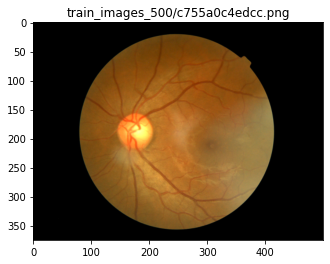

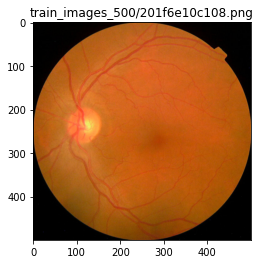

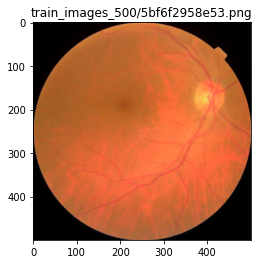

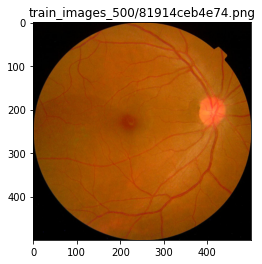

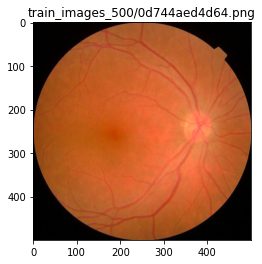

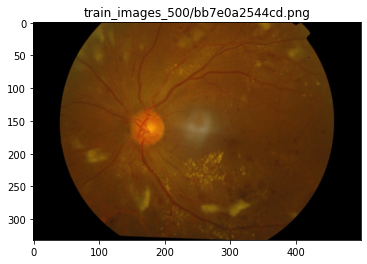

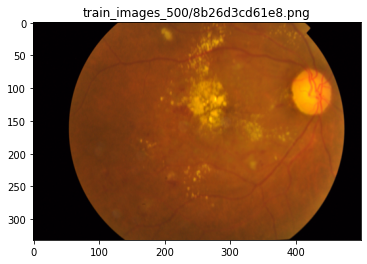

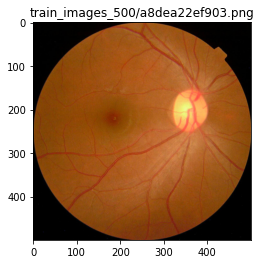

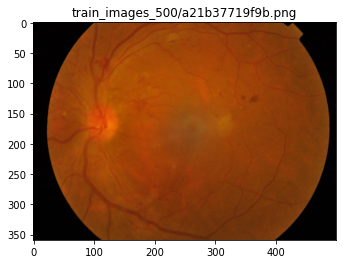

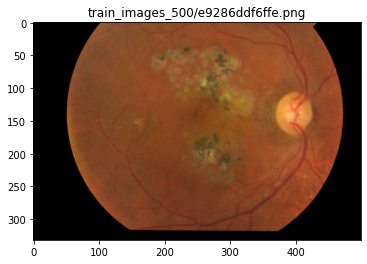

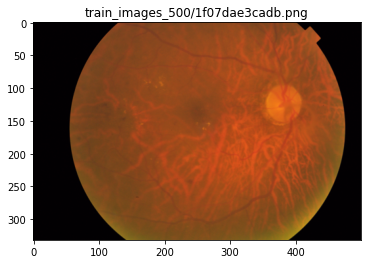

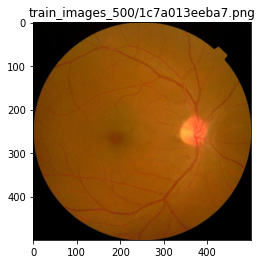

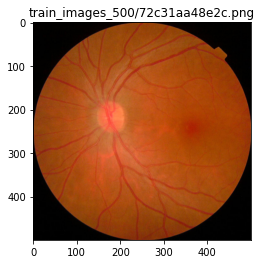

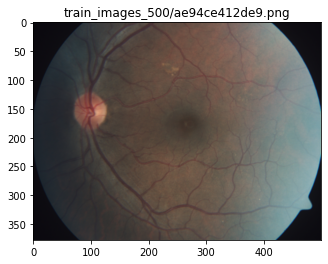

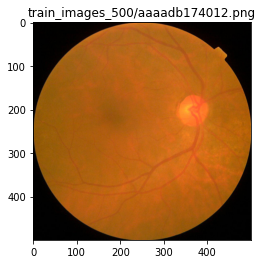

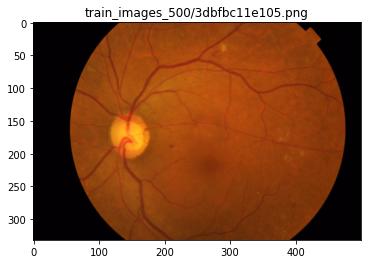

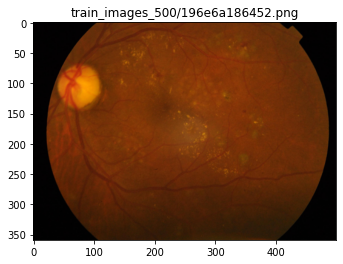

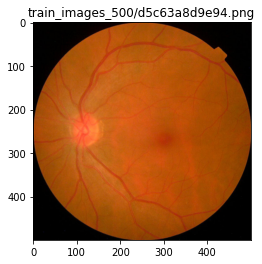

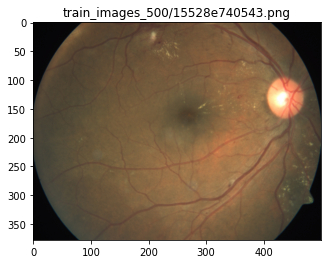

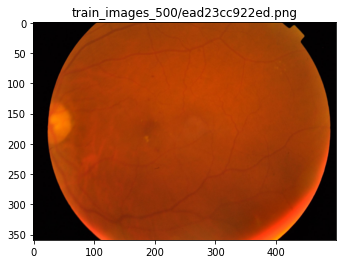

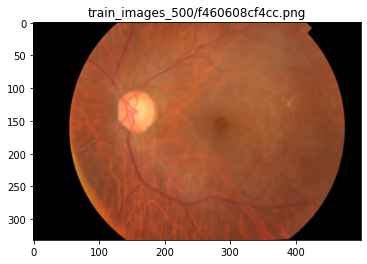

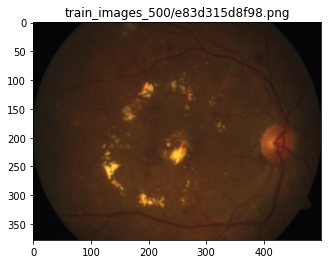

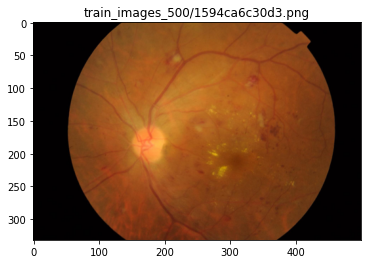

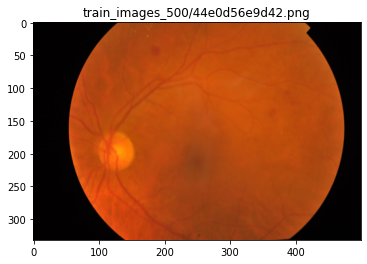

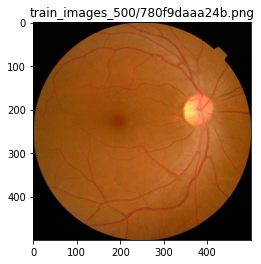

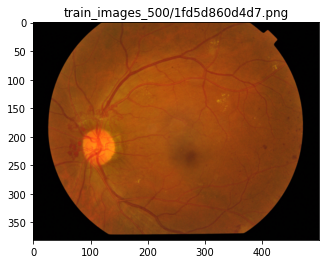

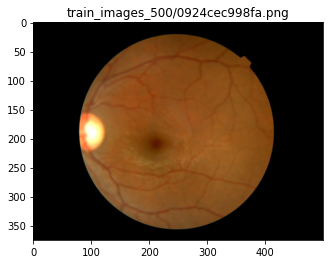

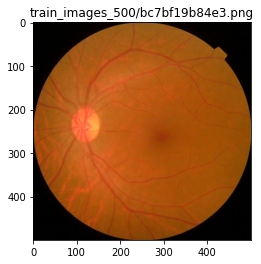

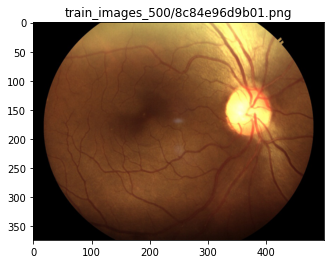

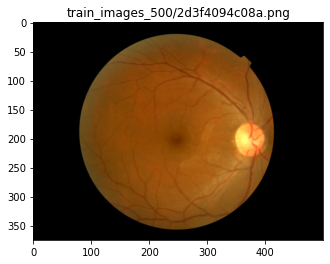

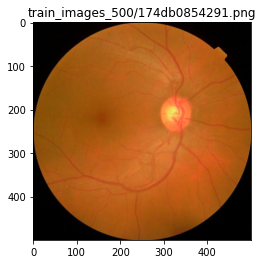

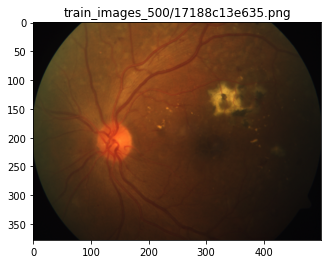

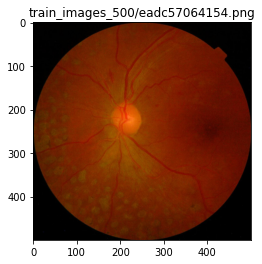

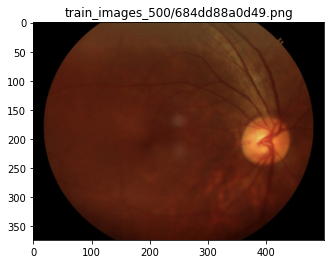

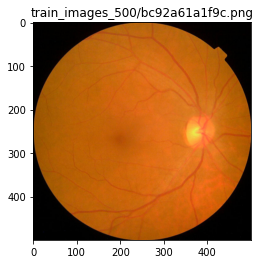

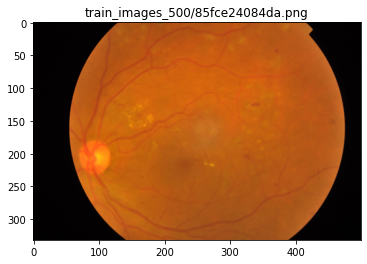

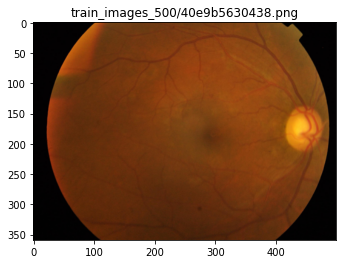

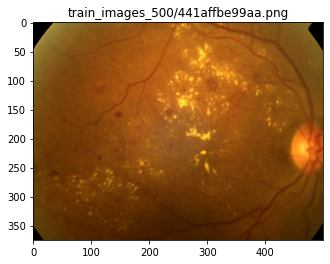

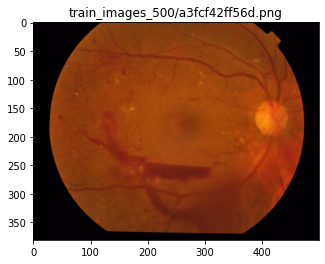

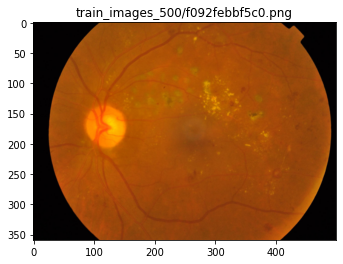

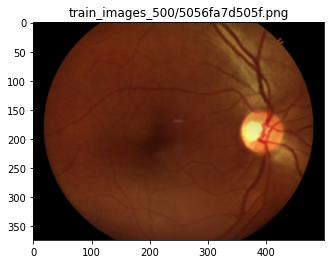

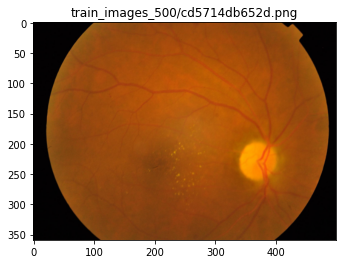

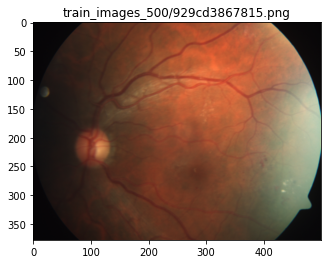

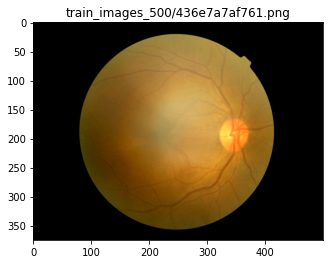

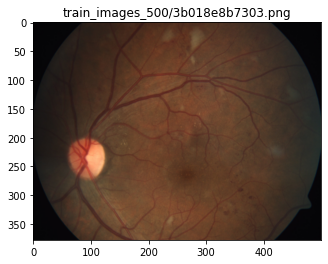

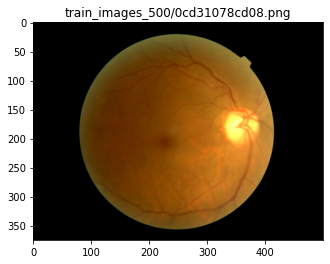

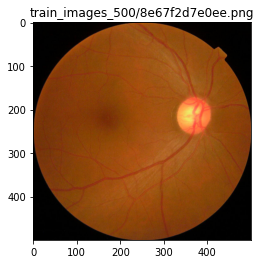

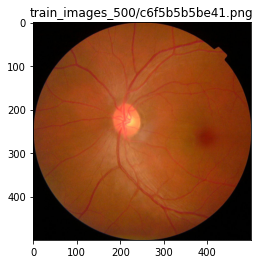

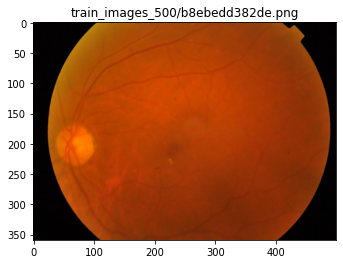

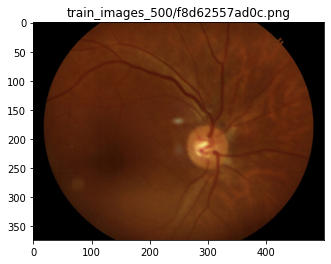

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for image in sample_images:
    plt.figure()
    img = mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.title(image)
    plt.show()

# Split dataset (training + validation + testing)

In [10]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(data, test_size=0.15)
print(f'Training: {len(train_set)} Validation: {len(validation_set)}')

Training: 3112 Validation: 550


In [11]:
class MyDataset(Dataset):
    
    def __init__(self,data,reshape=True,height=128,width=128,autoencoder=False):
        
        self.no_class = data[data['diagnosis']==0]['image_path'].tolist()
        self.mild_class = data[data['diagnosis']==1]['image_path'].tolist()
        self.moderate_class = data[data['diagnosis']==2]['image_path'].tolist()
        self.severe_class = data[data['diagnosis']==3]['image_path'].tolist()
        self.proliferative_class = data[data['diagnosis']==4]['image_path'].tolist()
        
        self.height = height
        self.width = width
        self.reshape = reshape
        self.autoencoder = autoencoder

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.mild_class))]
        labels += [2 for i in range(len(self.moderate_class))]
        labels += [3 for i in range(len(self.severe_class))]
        labels += [4 for i in range(len(self.proliferative_class))]

        links = self.no_class + self.mild_class + self.moderate_class + self.severe_class + self.proliferative_class

        self.dataframe = pd.DataFrame({"image":links, "labels":labels})
        self.dataframe.reset_index(inplace = True ,drop=True)
        
    def __len__(self):
        no_size = len(self.no_class)
        mild_size = len(self.mild_class)
        moderate_size = len(self.moderate_class)
        severe_size = len(self.severe_class)
        proliferative_size = len(self.proliferative_class)
        
        return no_size + mild_size + moderate_size + severe_size + proliferative_size
    
    def __getitem__(self,idx):

        image_list = self.dataframe["image"][idx]
        label_list = self.dataframe["labels"][idx]

        if type(image_list) == str: 
            image_list = [image_list]
            
        if not isinstance(label_list,np.int64):
            label_list = label_list.values
            
        image_array = []
        
        for image in image_list:
            image = Image.open(image).convert("L")
            
            if self.reshape:
                image = image.resize((self.height,self.width))
                
            array = np.asarray(image)
            
            array = array.reshape(1,self.height,self.width)
            
            image_array.append(array)
            
        return [torch.tensor(np.array(image_array),device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):

        # Use grouby and count to see if dataset is balanced
        count = self.dataframe.groupby(['labels'])['labels'].count()
        print(f'* Get count of each class label: \n{count}\n')

        return str(self.dataframe.head(5))

In [12]:
train_set = MyDataset(train_set)
train_set

* Get count of each class label: 
labels
0    1517
1     319
2     866
3     166
4     244
Name: labels, dtype: int64



                               image  labels
0  train_images_500/31360e44ac64.png       0
1  train_images_500/e9678824215d.png       0
2  train_images_500/1b398c0494d1.png       0
3  train_images_500/9d75de31f1b8.png       0
4  train_images_500/721214151233.png       0

In [13]:
validation_set = MyDataset(validation_set)
validation_set

* Get count of each class label: 
labels
0    288
1     51
2    133
3     27
4     51
Name: labels, dtype: int64



                               image  labels
0  train_images_500/7ce671f952be.png       0
1  train_images_500/a0fd94e2ad76.png       0
2  train_images_500/e69b48516577.png       0
3  train_images_500/ff03f74667df.png       0
4  train_images_500/b1c6f0997e27.png       0

# Custom CNN Model

In [14]:
class Model(nn.Module):
    
    def __init__(self):      
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,256,kernel_size=3), # 126*126*256
            nn.MaxPool2d(2,2), # 63*63*256
            nn.Conv2d(256,32,kernel_size=2) # 63-2+1 = 62*62*32
        )
        
        # n-f+2p/s +1 
        
        self.linear1 = nn.Linear(62,128)
        self.linear2 = nn.Linear(128,64)
        self.flat = nn.Flatten(1)
        self.linear3 = nn.Linear(126976,5) # 5 b/c there are 5 classes/labels
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)
        
        return x

In [15]:
model = Model()
model.to(device)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(256, 32, kernel_size=(2, 2), stride=(1, 1))
  )
  (linear1): Linear(in_features=62, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear3): Linear(in_features=126976, out_features=5, bias=True)
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
epochs = 10
batch_size = 32
loss_list = []

for epoch in range(epochs):
    total_loss = 0.0
    
    for n in range(len(train_set)//batch_size):
        data , target = train_set[n*batch_size : (n+1)*batch_size]
        
        ypred = model.forward(data.float())
        loss = loss_fn(ypred,target)
        
        total_loss+=loss
        
        optimizer.zero_grad() # clear the gradients
        loss.backward() # calculate the gradient
        optimizer.step() # Wn = Wo - lr * gradient
        
    loss_list.append(total_loss/batch_size)

    print("Epochs {}  Training Loss {:.2f}".format(epoch+1,total_loss/n))

Epochs 1  Training Loss 79.68
Epochs 2  Training Loss 9.35
Epochs 3  Training Loss 9.12
Epochs 4  Training Loss 8.80
Epochs 5  Training Loss 4.43
Epochs 6  Training Loss 2.21
Epochs 7  Training Loss 1.37
Epochs 8  Training Loss 1.61
Epochs 9  Training Loss 1.76
Epochs 10  Training Loss 1.62


# Save out trained model

In [18]:
modelname = 'ellie-trained-model-cpu-500.pth'
torch.save(model.state_dict(), modelname)

# Display convergence

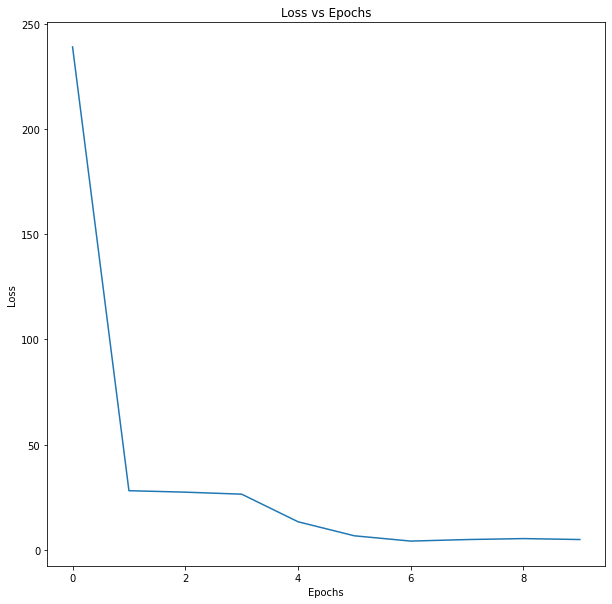

In [19]:
fig = plt.figure(figsize=(10,10))
plt.plot(list(range(epochs)),[x.tolist() for x in loss_list])
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Model evaluation

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate(model, validation_set, plot='no'):
    """Function evaluates model by calculating accuracy"""
    
    # Map labels to reference class
    mapping = {0:"No DR", 1:"Mild", 2:"Moderate", 3:"Severe", 4:"Proliferative DR"}

    # Ground truths vs. model predictions
    total = len(validation_set)
    
    actuals, predictions = [], []
    for i in range(total):
        print(f'Predicting {i+1}/{total}...')
        
        data, target = validation_set[i]
        
        pred = torch.argmax(model.forward(data.float()), dim=1)
        
        actual = mapping[target.cpu().detach().item()]
        prediction = mapping[pred.cpu().detach().item()]
        
        actuals.append(actual)
        predictions.append(prediction)
    
        # Plot results...
        if plot == 'yes':
            plt.figure()
            plt.imshow(data[0][0].cpu())
            plt.title(f"Actual : {actual} | Prediction : {prediction}")
            plt.show()
    
    # Build confusion matrix
    plt.figure(figsize=(10,6))
    fx=sns.heatmap(confusion_matrix(actuals,predictions), annot=True, fmt=".2f", cmap="GnBu")
    fx.set_title('Confusion Matrix \n');
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n');
    fx.xaxis.set_ticklabels(mapping.values())
    fx.yaxis.set_ticklabels(mapping.values())
    plt.show()
    
    # Calculate metrics
    print(classification_report(actuals, predictions))
    

Predicting 1/550...
Predicting 2/550...
Predicting 3/550...
Predicting 4/550...
Predicting 5/550...
Predicting 6/550...
Predicting 7/550...
Predicting 8/550...
Predicting 9/550...
Predicting 10/550...
Predicting 11/550...
Predicting 12/550...
Predicting 13/550...
Predicting 14/550...
Predicting 15/550...
Predicting 16/550...
Predicting 17/550...
Predicting 18/550...
Predicting 19/550...
Predicting 20/550...
Predicting 21/550...
Predicting 22/550...
Predicting 23/550...
Predicting 24/550...
Predicting 25/550...
Predicting 26/550...
Predicting 27/550...
Predicting 28/550...
Predicting 29/550...
Predicting 30/550...
Predicting 31/550...
Predicting 32/550...
Predicting 33/550...
Predicting 34/550...
Predicting 35/550...
Predicting 36/550...
Predicting 37/550...
Predicting 38/550...
Predicting 39/550...
Predicting 40/550...
Predicting 41/550...
Predicting 42/550...
Predicting 43/550...
Predicting 44/550...
Predicting 45/550...
Predicting 46/550...
Predicting 47/550...
Predicting 48/550...
P

Predicting 383/550...
Predicting 384/550...
Predicting 385/550...
Predicting 386/550...
Predicting 387/550...
Predicting 388/550...
Predicting 389/550...
Predicting 390/550...
Predicting 391/550...
Predicting 392/550...
Predicting 393/550...
Predicting 394/550...
Predicting 395/550...
Predicting 396/550...
Predicting 397/550...
Predicting 398/550...
Predicting 399/550...
Predicting 400/550...
Predicting 401/550...
Predicting 402/550...
Predicting 403/550...
Predicting 404/550...
Predicting 405/550...
Predicting 406/550...
Predicting 407/550...
Predicting 408/550...
Predicting 409/550...
Predicting 410/550...
Predicting 411/550...
Predicting 412/550...
Predicting 413/550...
Predicting 414/550...
Predicting 415/550...
Predicting 416/550...
Predicting 417/550...
Predicting 418/550...
Predicting 419/550...
Predicting 420/550...
Predicting 421/550...
Predicting 422/550...
Predicting 423/550...
Predicting 424/550...
Predicting 425/550...
Predicting 426/550...
Predicting 427/550...
Predicting

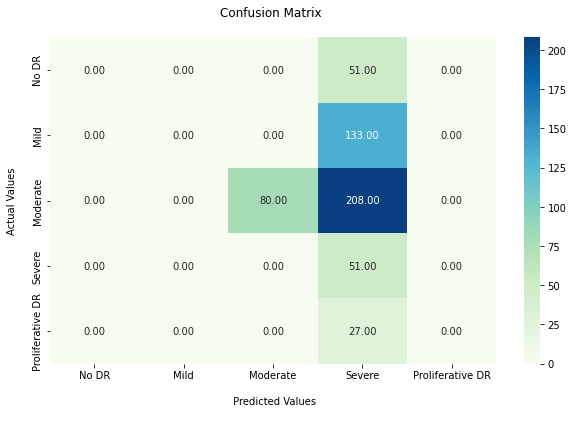

                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        51
        Moderate       0.00      0.00      0.00       133
           No DR       1.00      0.28      0.43       288
Proliferative DR       0.11      1.00      0.20        51
          Severe       0.00      0.00      0.00        27

        accuracy                           0.24       550
       macro avg       0.22      0.26      0.13       550
    weighted avg       0.53      0.24      0.25       550



In [21]:
evaluate(model, validation_set, plot='no')

# (Optional) Continue training

In [22]:
def continue_training(model, train_set, loss_list, epochs=5, batch_size=32):
    """Function continues training your model"""

    for epoch in range(epochs):
        total_loss = 0.0
    
        for n in range(len(train_set)//batch_size):
            data , target = train_set[n*batch_size : (n+1)*batch_size]
        
            ypred = model.forward(data.float())
            loss = loss_fn(ypred,target)
        
            total_loss+=loss
        
            optimizer.zero_grad() # clear the gradients
            loss.backward() # calculate the gradient
            optimizer.step() # Wn = Wo - lr * gradient
        
        loss_list.append(total_loss/batch_size)

        print("Epochs {}  Training Loss {:.2f}".format(epoch+1,total_loss/n))
        
    return model, loss_list

Epochs 1  Training Loss 1.94
Epochs 2  Training Loss 1.70
Epochs 3  Training Loss 2.56
Epochs 4  Training Loss 2.03
Epochs 5  Training Loss 3.59
Predicting 1/550...
Predicting 2/550...
Predicting 3/550...
Predicting 4/550...
Predicting 5/550...
Predicting 6/550...
Predicting 7/550...
Predicting 8/550...
Predicting 9/550...
Predicting 10/550...
Predicting 11/550...
Predicting 12/550...
Predicting 13/550...
Predicting 14/550...
Predicting 15/550...
Predicting 16/550...
Predicting 17/550...
Predicting 18/550...
Predicting 19/550...
Predicting 20/550...
Predicting 21/550...
Predicting 22/550...
Predicting 23/550...
Predicting 24/550...
Predicting 25/550...
Predicting 26/550...
Predicting 27/550...
Predicting 28/550...
Predicting 29/550...
Predicting 30/550...
Predicting 31/550...
Predicting 32/550...
Predicting 33/550...
Predicting 34/550...
Predicting 35/550...
Predicting 36/550...
Predicting 37/550...
Predicting 38/550...
Predicting 39/550...
Predicting 40/550...
Predicting 41/550...
Pre

Predicting 377/550...
Predicting 378/550...
Predicting 379/550...
Predicting 380/550...
Predicting 381/550...
Predicting 382/550...
Predicting 383/550...
Predicting 384/550...
Predicting 385/550...
Predicting 386/550...
Predicting 387/550...
Predicting 388/550...
Predicting 389/550...
Predicting 390/550...
Predicting 391/550...
Predicting 392/550...
Predicting 393/550...
Predicting 394/550...
Predicting 395/550...
Predicting 396/550...
Predicting 397/550...
Predicting 398/550...
Predicting 399/550...
Predicting 400/550...
Predicting 401/550...
Predicting 402/550...
Predicting 403/550...
Predicting 404/550...
Predicting 405/550...
Predicting 406/550...
Predicting 407/550...
Predicting 408/550...
Predicting 409/550...
Predicting 410/550...
Predicting 411/550...
Predicting 412/550...
Predicting 413/550...
Predicting 414/550...
Predicting 415/550...
Predicting 416/550...
Predicting 417/550...
Predicting 418/550...
Predicting 419/550...
Predicting 420/550...
Predicting 421/550...
Predicting

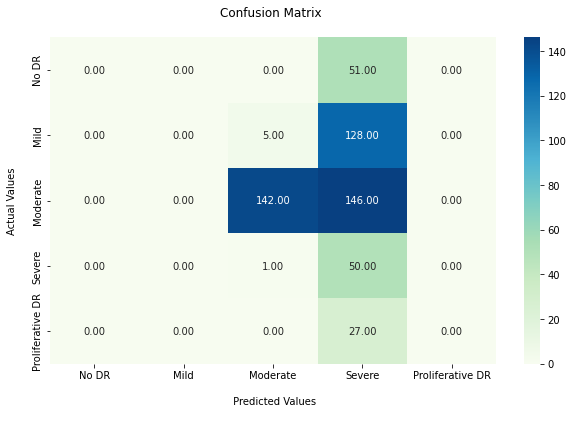

                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        51
        Moderate       0.00      0.00      0.00       133
           No DR       0.96      0.49      0.65       288
Proliferative DR       0.12      0.98      0.22        51
          Severe       0.00      0.00      0.00        27

        accuracy                           0.35       550
       macro avg       0.22      0.29      0.17       550
    weighted avg       0.51      0.35      0.36       550



In [23]:
# Second pass
updated_model, updated_loss_list = continue_training(model, train_set, loss_list, epochs=5, batch_size=32)

# Save out updated model
modelname = 'ellie-trained-model-cpu-500-updated.pth'
torch.save(updated_model.state_dict(), modelname)

# Evaluate with updated model
evaluate(updated_model, validation_set, plot='no')

# Summary